# Batchzahlen_Gesamt

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import floor
from datetime import date, timedelta

#for archiving
import os 
import argparse

#for reporting 
#import perf
from pandas.plotting import register_matplotlib_converters

from numpy import asarray
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, Input, concatenate, ConvLSTM2D, MaxPooling2D,Conv2D, ConvLSTM1D
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from matplotlib.patches import ConnectionPatch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import sklearn
import math
import keras

In [ ]:
protokoll_path = r"00_Daten/abschreibung.csv"
abschreibungen = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)

protokoll_path = r"00_Daten/test_datensatz.csv"
batchzahlen_gesamt = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)

protokoll_path = r"00_Daten/dps_lagerbelegung.csv"
dps_lagerbelegung = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)

protokoll_path = r"00_Daten/Filialen_Pro_Tag_DPS.csv"
filialen_Pro_Tag_DPS = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)

protokoll_path = r"00_Daten/We_te_eingelagert.csv"
we_te_eingelagert = pd.read_csv(
    protokoll_path, encoding='unicode_escape', sep=";", error_bad_lines=True)


abschreibungen = abschreibungen[abschreibungen["Lager"] == "DPS"]
abschreibungen = abschreibungen[["Datum", "Anteil_in_Prozent"]]
abschreibungen.columns = ["Datum", "Abschreibung_in_Prozent"]

batchzahlen_gesamt = batchzahlen_gesamt[batchzahlen_gesamt["Lager"] == "DPS"]
batchzahlen_gesamt = batchzahlen_gesamt[["ï»¿Datum", "VPE_Gesamt"]]
batchzahlen_gesamt.columns = ["Datum", "Bestellzahlen_Gesamt"]

dps_lagerbelegung["Lager_Auslastung"] = dps_lagerbelegung["Belegt"] / dps_lagerbelegung["Gesamt"]
dps_lagerbelegung = dps_lagerbelegung[["Datum", "Lager_Auslastung"]]
dps_lagerbelegung.columns = ["Datum", "Lager_Auslastung"]


filialen_Pro_Tag_DPS = filialen_Pro_Tag_DPS[["Packdatum", "Filialen"]]
filialen_Pro_Tag_DPS.columns = ["Datum", "Filialen_Kommissioniert_Gesamt"]

we_te_eingelagert = we_te_eingelagert[we_te_eingelagert["Lager"] == "DPS"]
we_te_eingelagert = we_te_eingelagert[["Datum", "TE"]]
we_te_eingelagert.columns = ["Datum", "Te_Eingelagert"]

abschreibungen["Datum"] = pd.to_datetime(abschreibungen["Datum"])
batchzahlen_gesamt["Datum"] = pd.to_datetime(batchzahlen_gesamt["Datum"])
dps_lagerbelegung["Datum"] = pd.to_datetime(dps_lagerbelegung["Datum"])
filialen_Pro_Tag_DPS["Datum"] = pd.to_datetime(filialen_Pro_Tag_DPS["Datum"])
we_te_eingelagert["Datum"] = pd.to_datetime(we_te_eingelagert["Datum"])


In [ ]:
batchzahlen_gesamt['year'] = pd.DatetimeIndex(batchzahlen_gesamt['Datum']).year
batchzahlen_gesamt['month'] = pd.DatetimeIndex(
    batchzahlen_gesamt['Datum']).month
batchzahlen_gesamt['week'] = pd.DatetimeIndex(
    batchzahlen_gesamt['Datum']).week
batchzahlen_gesamt['year_month'] = pd.to_datetime(
    batchzahlen_gesamt['Datum']).dt.to_period('M')
batchzahlen_gesamt['day'] = pd.DatetimeIndex(batchzahlen_gesamt['Datum']).day
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['Datum'].dt.day_name()
batchzahlen_gesamt.sort_values(by=['Datum'], ascending=True)
batchzahlen_gesamt.reset_index(drop=True, inplace=True)
batchzahlen_gesamt = batchzahlen_gesamt[batchzahlen_gesamt["day_of_week"] != "Sunday"]

In [ ]:
import datetime
import calendar

def week_of_month(tgtdate):
    #tgtdate = tgtdate.to_datetime()

    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we canuse the modulo 7 appraoch
    return (tgtdate - startdate).days //7 + 1

#all_dates = all_dates.reset_index()
batchzahlen_gesamt['week_of_month'] = batchzahlen_gesamt["Datum"].apply(week_of_month)

In [ ]:
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Monday'],'Montag')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Tuesday'],'Dienstag')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Wednesday'],'Mittwoch')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Thursday'],'Donnerstag')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Friday'],'Freitag')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Saturday'],'Samstag')
batchzahlen_gesamt['day_of_week'] = batchzahlen_gesamt['day_of_week'].replace(['Sunday'],'Sonntag')


In [ ]:
wochentage = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]
df = pd.DataFrame(columns=list(batchzahlen_gesamt.columns))
for i in range(0,len(wochentage) -1):
    day = batchzahlen_gesamt[batchzahlen_gesamt["day_of_week"] == wochentage[i]]
    day = day[day["Bestellzahlen_Gesamt"] < np.percentile(day["Bestellzahlen_Gesamt"], 97)]
    day = day[day["Bestellzahlen_Gesamt"] > np.percentile(day["Bestellzahlen_Gesamt"], 3)]
    df = pd.concat([df,day])
batchzahlen_gesamt = df.sort_index()

In [ ]:
# "broken" (staggered) dates
dates =batchzahlen_gesamt["Datum"]
all_dates = pd.Series(batchzahlen_gesamt["Bestellzahlen_Gesamt"].tolist(), dates)
all_dates = all_dates.asfreq('D')
all_dates.interpolate(method='time', inplace=True)
all_dates = all_dates.to_frame().reset_index()
all_dates = all_dates.rename(columns= {0: 'Bestellzahlen_Gesamt'})

In [216]:
all_dates['year'] = pd.DatetimeIndex(all_dates['Datum']).year
all_dates['day_of_week'] = all_dates['Datum'].dt.day_name()

only_since_2017 = all_dates[all_dates["year"] >= 2018 ]
only_since_2017.reset_index(drop=True, inplace=True)

all_dates.set_index("Datum",inplace = True)

# Feature Selektion

## Äquivalente Monate letzten 3 Jahre

In [ ]:
n_steps = 90
steps_year = 30

X = []
Y = []
i = 0
for i in range(7, len(only_since_2017) - 6 - steps_3_monate): 
    Y.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,"Bestellzahlen_Gesamt"])

    a = all_dates.loc[only_since_2017.loc[i,"Datum"]:
                      only_since_2017.loc[i,"Datum"] + timedelta(steps_year -1),
                      "Bestellzahlen_Gesamt"]
    

    b = all_dates.loc[only_since_2017.loc[i,"Datum"] - timedelta(365): 
                      only_since_2017.loc[i,"Datum"] - timedelta(365 - steps_year +1),
                      "Bestellzahlen_Gesamt"]
    
    c = all_dates.loc[only_since_2017.loc[i,"Datum"] - timedelta(365 * 2):
                      only_since_2017.loc[i,"Datum"] - timedelta(365 * 2 - steps_year +1) ,
                      "Bestellzahlen_Gesamt"]

    ss = pd.concat([c,b,a])
    ss = ss[::-1]
    print(len(ss))
    X.append(np.array(ss))

print(len(X))
X1 = np.array(X).reshape(-1, n_steps, 1)
Y1 = np.array(Y)

## Äquivalente Woche Davor und danach 

In [221]:
n_steps = 42
steps_week = 5

X = []
Y = []
check = []
i = 0
for i in range(7, len(only_since_2017) - 6 - steps_3_monate): 
    Y.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,"Bestellzahlen_Gesamt"])
    
    a = all_dates.loc[only_since_2017.loc[i,"Datum"] - timedelta(365 - steps_week * 4): 
                      only_since_2017.loc[i,"Datum"] - timedelta(365 - steps_week * 8),
                      "Bestellzahlen_Gesamt"]
 
    b = all_dates.loc[only_since_2017.loc[i,"Datum"] - timedelta(365 * 2 - steps_week * 4):
                      only_since_2017.loc[i,"Datum"] - timedelta(365 * 2 - steps_week * 8),
                      "Bestellzahlen_Gesamt"]
    
    
    ss = pd.concat([b,a])
    ss = ss[::-1]
    
    X.append(np.array(ss))



X2 = np.array(X).reshape(-1, n_steps, 1)
Y2 = np.array(Y)

## Äquivalente KW Im Monat letzten Monate 

In [222]:
n_steps = 7 * 6
steps_year = 30

X = []
Y = []
i = 0
for i in range(7, len(only_since_2017) - 6 - steps_3_monate): 
    Y.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,"Bestellzahlen_Gesamt"])

    a = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days=28)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days=28)).date()),"Bestellzahlen_Gesamt"]
    
    b = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days=28 + 35)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days=28 + 35)).date()),"Bestellzahlen_Gesamt"]
        
    c = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days= 28 + 35 + 28)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days= 28 + 35 +28)).date()),"Bestellzahlen_Gesamt"]
    
    d = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35)).date()),"Bestellzahlen_Gesamt"]
        
    e = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35 +28)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35 +28 )).date()),"Bestellzahlen_Gesamt"]
    
    f = all_dates.loc[str((only_since_2017.loc[i + steps_year,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35 +28 +35)).date()) :
             str((only_since_2017.loc[i + steps_year + 6,"Datum"] - pd.DateOffset(days=28 + 35 +28 +35 +28 +35 )).date()),"Bestellzahlen_Gesamt"]
    
        
        

    ss = pd.concat([f,e,d,c,b,a])
    ss = ss[::-1]
    
    X.append(np.array(ss))


X3 = np.array(X).reshape(-1, n_steps, 1)
Y3 = np.array(Y)

## Andere Daten 

In [24]:
only_since_2017.set_index("Datum",inplace = True)
dps_lagerbelegung.set_index("Datum",inplace = True)
filialen_Pro_Tag_DPS.set_index("Datum",inplace = True)
we_te_eingelagert.set_index("Datum",inplace = True)

In [25]:
merge=pd.merge(only_since_2017,dps_lagerbelegung, how='left', left_index=True, right_index=True)
merge=pd.merge(merge,filialen_Pro_Tag_DPS, how='left', left_index=True, right_index=True)
merged =pd.merge(merge,we_te_eingelagert, how='left', left_index=True, right_index=True)
only_since_2017.reset_index(drop=False, inplace=True)

In [26]:
merged.interpolate(method='linear', inplace=True)

In [27]:
#2017-02-07 erster welcher vorhergesagt wird.
mer = merged[(merged.index >= "2017-01-28") & (merged.index <= "2021-11-03") ]

In [28]:
n_steps_lager_auslastung = 4
n_steps_lager_Filialen = 10
n_steps_Te_eingelagert = 10 
i = 0
X4 = []
X5 = []
X6 = []
Y = []
check = []

for i in range(7, len(only_since_2017) - 6 - steps_3_monate): 
    
    Y.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,"Bestellzahlen_Gesamt"])
    check.append(only_since_2017.loc[i + steps_year: i + steps_year + 6 ,:])
    
    a = mer.loc[only_since_2017.loc[i,"Datum"] + timedelta(steps_year -n_steps_lager_auslastung) :
                only_since_2017.loc[i,"Datum"] + timedelta(steps_year -1),
                "Lager_Auslastung"]
    
    b = mer.loc[only_since_2017.loc[i,"Datum"] + timedelta(steps_year -n_steps_lager_Filialen) :
                only_since_2017.loc[i,"Datum"] + timedelta(steps_year -1),
                "Filialen_Kommissioniert_Gesamt"]
        
    c = mer.loc[only_since_2017.loc[i,"Datum"] + timedelta(steps_year -n_steps_Te_eingelagert) :
                only_since_2017.loc[i,"Datum"] + timedelta(steps_year -1),
                "Te_Eingelagert"]

    

    aa = a[::-1]
    X4.append(np.array(aa))
    bb = b[::-1]
    X5.append(np.array(bb))
    cc = c[::-1]
    X6.append(np.array(cc))

X4 = np.array(X4).reshape(-1, n_steps_lager_auslastung, 1)
X5 = np.array(X5).reshape(-1, n_steps_lager_Filialen, 1)
X6 = np.array(X6).reshape(-1, n_steps_Te_eingelagert, 1)
Y3 = np.array(Y)

In [ ]:
print(np.array_equal(Y1,Y2))
print(np.array_equal(Y2,Y3))

In [ ]:
print(X1.shape)
print(X2.shape)
print(X3.shape)
print(X4.shape)
print(X5.shape)
print(X6.shape)

# Model bauen 

In [ ]:
X1_train, X1_test,X2_train, X2_test,X3_train, X3_test,X4_train,X4_test,X5_train,X5_test,X6_train,X6_test, y_train, y_test = train_test_split(
    X1,X2,X3,X4,X5,X6, Y1, test_size=0.1,  random_state=46, shuffle = False)

In [ ]:
print(X1_train.shape)
print(X2_train.shape)
print(X3_train.shape)
print(X4_train.shape)
print(X5_train.shape)

print(X1_test.shape)
print(X2_test.shape)
print(X3_test.shape)
print(X4_test.shape)
print(X5_test.shape)

# Naives Forecasting

In [ ]:
mse_naives_forecasting_multi = sklearn.metrics.mean_squared_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])
mae_naives_forecasting_multi = sklearn.metrics.mean_absolute_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])
mape_naives_forecasting_multi = sklearn.metrics.mean_absolute_percentage_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])
print("Naives Forecasting")
print("RMSE_Naive: %s" % round(math.sqrt(mse_naives_forecasting_multi),2))
print("MAE_Naive: %s" % round(mae_naives_forecasting_multi,2))
print("MAPE_Naive: %s" % round(mape_naives_forecasting_multi,2))
print("")



In [ ]:
try:
    mse = math.sqrt(sklearn.metrics.mean_squared_error(prog_dez["REAL"], prog_dez["DPS"]))
    mae = sklearn.metrics.mean_absolute_error(prog_dez["REAL"], prog_dez["DPS"])
    mape = sklearn.metrics.mean_absolute_percentage_error(prog_dez["REAL"], prog_dez["DPS"])
except Exception as e:
    print("An exception occurred: ", e)
        
print("Naives Forecasting")
print("RMSE_Naive: %s" % round(mse,2))
print("MAE_Naive: %s" % round(mae,2))
print("MAPE_Naive: %s" % round(mape,2))
print("")


# Univariate Modelle

## CNN

In [ ]:
def get_model_cnn(filters=2,kernel_size=4,pool_size=2,optimizer = "adam", loss = "mse", training= training):
    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(training.shape[1],
    training.shape[2])))
    model_cnn.add(MaxPooling1D(pool_size=pool_size))
    model_cnn.add(Flatten())
    #model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(30, activation='relu'))
    model_cnn.add(Dense(7))
    model_cnn.compile(optimizer=optimizer, loss=loss)
    #model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                      #loss=tf.keras.losses.Huber())
                      #loss= "mse"
    return model_cnn

def fit_model_cnn(filters,kernel_size,pool_size,
                  epochs, batch_size,training, 
                  y_train, test, y_test,verbose,optimizer ,loss):
    
    model_cnn = get_model_cnn(filters,kernel_size,pool_size,optimizer,loss,training)
    model_history_cnn = model_cnn.fit(training, y_train, 
                                  validation_data=(test, y_test), 
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  verbose= verbose)

    return model_history_cnn, model_cnn,[test]

    
    

   


## LSTM / RNN

In [ ]:
def get_model_lstm1(lstm_units,optimizer,loss,training):
    model_lstm1 = Sequential()
    model_lstm1.add(LSTM(40, activation='relu', return_sequences=True, input_shape=(training.shape[1],training.shape[2])))
   # model_lstm1.add(LSTM(25, activation='relu', return_sequences=Dense))
    model_lstm1.add(LSTM(20, activation='relu'))
    model_lstm1.add(Dense(20, activation='relu'))
    model_lstm1.add(Dense(7)) 
    model_lstm1.compile(optimizer=optimizer, loss=loss)
    return model_lstm1

def fit_model_lstm1(lstm_units,optimizer,loss,training,y_train,test,y_test,epochs,batch_size,verbose):
    model_lstm1 = get_model_lstm1(lstm_units,optimizer,loss,training)
    model_lstm1_history = model_lstm1.fit(training, y_train, validation_data=(test, y_test), 
                                          epochs=epochs,batch_size= batch_size,
                                          verbose=verbose)
    return model_lstm1_history, model_lstm1

In [ ]:
def get_model_lstm2(lstm_units,optimizer,loss,training):
    model_lstm2 = Sequential()
    model_lstm2.add(LSTM(lstm_units, activation='relu', input_shape=(training.shape[1], training.shape[2])))
    model_lstm2.add(Dense(7))
    model_lstm2.compile(loss=loss, optimizer=optimizer)
    return model_lstm2

def fit_model_lstm2(lstm_units,optimizer,loss,training,y_train,test,y_test,epochs,batch_size,verbose):
    model_lstm2 = get_model_lstm2(lstm_units,optimizer,loss,training)
    model_lstm2_history = model_lstm2.fit(training, y_train, validation_data=(test, y_test), 
                                          epochs=epochs,batch_size= batch_size,
                                          verbose=verbose)
    return model_lstm2_history, model_lstm2
    
    


### Lstm Bidiectional

In [ ]:
def get_model_lstm_bidirectional(lstm_units,optimizer,loss,training):
    model_lstm_bi = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True),input_shape=(training.shape[1], training.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = int(lstm_units/2))),
        tf.keras.layers.Dense(30),
        tf.keras.layers.Dense(7)
        #tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    model_lstm_bi.compile(loss=loss, optimizer=optimizer)
    return model_lstm_bi
    
def fit_model_lstm_bidirectional(lstm_units,optimizer,loss,training,y_train,test,y_test,epochs,batch_size,verbose):
    model_lstm_bi = get_model_lstm_bidirectional(lstm_units,optimizer,loss,training)
    model_lstm_bi_history = model_lstm_bi.fit(training, y_train, validation_data=(test, y_test), 
                                          epochs=epochs,batch_size= batch_size,
                                          verbose=verbose)
    return model_lstm_bi_history, model_lstm_bi

## LSTM_CNN

In [ ]:
def get_model_lstm_cnn(filters,kernel_size,pool_size,lstm_units,optimizer,loss,training_series_sub):

    #print('Train set shape', training_series_sub.shape)
    #print('Validation set shape', test_series_sub.shape)

    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'), 
                                       input_shape=(None, training_series_sub.shape[2], training_series_sub.shape[3])))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=pool_size)))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(lstm_units, activation='relu'))
    model_cnn_lstm.add(Dense(7))
    model_cnn_lstm.compile(loss=loss, optimizer=optimizer)
    return model_cnn_lstm
    
def fit_model_lstm_cnn(filters,kernel_size,pool_size,lstm_units,optimizer,
                       loss,training,y_train,test,y_test,epochs,batch_size,verbose):
    subsequences = 2
    timesteps = training.shape[1]//subsequences
    training_series_sub = training.reshape((training.shape[0], subsequences, timesteps, 1))
    test_series_sub = test.reshape((test.shape[0], subsequences, timesteps, 1))
    
    model_cnn_lstm = get_model_lstm_cnn(filters,kernel_size,pool_size,lstm_units,optimizer,loss,training_series_sub)
    
    cnn_lstm_history = model_cnn_lstm.fit(training_series_sub, y_train, 
                                          validation_data=(test_series_sub, y_test), 
                                          epochs=epochs, verbose=verbose, batch_size = batch_size)
    return cnn_lstm_history, model_cnn_lstm, test_series_sub
    


# Encoder Decoder

## CNN-LSTM Encoder Decoder

In [ ]:
#S 418
def get_model_E_D_lstm_cnn(filters, kernel_size,pool_size,lstm_units,loss,optimizer,training,y_train_re):
    # define model
    model_E_D_lstm_cnn = Sequential()
    model_E_D_lstm_cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
                                  input_shape=(training.shape[1],training.shape[2])))
    model_E_D_lstm_cnn.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')) 
    model_E_D_lstm_cnn.add(MaxPooling1D(pool_size=pool_size))
    model_E_D_lstm_cnn.add(Flatten())
    model_E_D_lstm_cnn.add(RepeatVector(y_train_re.shape[1]))
    model_E_D_lstm_cnn.add(LSTM(lstm_units, activation='relu', return_sequences=True)) 
    model_E_D_lstm_cnn.add(TimeDistributed(Dense(100, activation='relu'))) 
    model_E_D_lstm_cnn.add(TimeDistributed(Dense(1)))
    model_E_D_lstm_cnn.compile(loss=loss, optimizer=optimizer)
    return model_E_D_lstm_cnn
# fit network
def fit_model_E_D_lstm_cnn(filters, kernel_size,pool_size,lstm_units,loss,optimizer,
                           training,test,epochs,verbose,batch_size,y_train,y_test):
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    model_E_D_lstm_cnn = get_model_E_D_lstm_cnn(filters, kernel_size,pool_size,lstm_units,loss,
                                                optimizer,training,y_train_re)
    
    model_E_D_lstm_cnn_history = model_E_D_lstm_cnn.fit(training, y_train_re, 
                                                        validation_data=(test, y_test_re),
                                                        epochs=epochs, verbose=verbose, batch_size = batch_size)
    return model_E_D_lstm_cnn_history, model_E_D_lstm_cnn


## Encoder Decoder LSTM

In [ ]:
# Encoder Decoder LSTM with unicvariante Input

def get_model_E_D_lstm(lstm_units,loss,optimizer,training,y_train_re):
    model_E_D_lstm = Sequential()
    model_E_D_lstm.add(LSTM(lstm_units, activation='relu', input_shape=(training.shape[1],training.shape[2]))) 
    model_E_D_lstm.add(RepeatVector(y_train_re.shape[1]))
    model_E_D_lstm.add(LSTM(lstm_units, activation='relu', return_sequences=True)) 
    model_E_D_lstm.add(TimeDistributed(Dense(50, activation='relu'))) 
    model_E_D_lstm.add(TimeDistributed(Dense(1)))
    model_E_D_lstm.compile(loss=loss, optimizer=optimizer)
    return model_E_D_lstm
    # fit network
def fit_model_E_D_lstm(lstm_units,loss,optimizer,
                       training,test,epochs,verbose,y_train,y_test,
                       batch_size):
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    model_E_D_lstm = get_model_E_D_lstm(lstm_units,loss,optimizer,training,y_train_re)
    
    model_E_D_lstm_history = model_E_D_lstm.fit(training, y_train_re, 
                                                validation_data=(test, y_test_re), 
                                                epochs=epochs, verbose=verbose, batch_size = batch_size)
    return model_E_D_lstm_history, model_E_D_lstm


## ConvLSTM Encoder Decoder

In [ ]:
#S 424
# define model
def get_model_ConvLSTM(filters,lstm_units,loss,optimizer,training,y_train_re):
    ConvLSTM_D_E = Sequential()
    ConvLSTM_D_E.add(ConvLSTM2D(filters=filters, kernel_size=(1,3), activation='relu',
    input_shape=(1, 1, training.shape[1], training.shape[2]))) 
    ConvLSTM_D_E.add(Flatten())
    ConvLSTM_D_E.add(RepeatVector(y_train_re.shape[1]))
    ConvLSTM_D_E.add(LSTM(lstm_units, activation='relu', return_sequences=True))
    ConvLSTM_D_E.add(TimeDistributed(Dense(100, activation='relu'))) 
    ConvLSTM_D_E.add(TimeDistributed(Dense(1)))
    ConvLSTM_D_E.compile(loss=loss, optimizer=optimizer)
    return ConvLSTM_D_E

def fit_model_ConvLSTM(filters,lstm_units,loss,optimizer,
                       training,y_train,y_test,test,epochs,verbose,batch_size): 
    
    train_re = training.reshape(training.shape[0],1, 1, training.shape[1], training.shape[2])
    test_re = test.reshape(test.shape[0],1, 1, test.shape[1], test.shape[2])
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    ConvLSTM_D_E = get_model_ConvLSTM(filters,lstm_units,loss,optimizer,training,y_train_re)
    
    model_ConvLSTM_D_E_history = ConvLSTM_D_E.fit(train_re, y_train_re, 
                                         validation_data=(test_re, y_test_re), 
                                         epochs=epochs, verbose=verbose, batch_size = batch_size)
    
    return model_ConvLSTM_D_E_history,ConvLSTM_D_E,test_re


# Ergebnisse Univariate Modelle

In [ ]:
def model_prediction(name,model,x_test,y_test):
    predictions = model.predict(x_test)
    predictions = predictions.reshape(-1,7)
    
    try:
        mse = math.sqrt(sklearn.metrics.mean_squared_error(y_test, predictions))
        mae = sklearn.metrics.mean_absolute_error(y_test, predictions)
        mape = sklearn.metrics.mean_absolute_percentage_error(y_test, predictions)
    except Exception as e:
        print("An exception occurred: ", e)
        
    mse = round(mse,0)
    mae = round(mae,0)
    mape = round(mape,2)
    return name,mse,mae,mape, predictions

    

In [ ]:
def plot_losses(model_history,name):
    plt.plot(model_history.history['loss'][10:])
    plt.plot(model_history.history['val_loss'][10:])
    plt.title(name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
#Ergebnisse Naives Forecsting
mse_naives_forecasting_multi = sklearn.metrics.mean_squared_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])
mae_naives_forecasting_multi = sklearn.metrics.mean_absolute_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])
mape_naives_forecasting_multi = sklearn.metrics.mean_absolute_percentage_error(Y1[1:,:], Y1[0:Y1.shape[0] -1,:])


# Multiheaded Models

## Multi CNN

In [ ]:
def get_model_multi_CNN_X1_X2(filters1,filters2,kernel_size1,kernel_size2,
                              pool_size1,pool_size2,optimizer,loss,
                              X1_train,X2_train,X3_train):
    # head 1
    inputs1 = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
    conv1 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs1)
    max1 = MaxPooling1D(pool_size=pool_size1)(conv1)
    flat1 = Flatten()(max1)
    # head 2
    inputs2 = Input(shape=(X2_train.shape[1],X2_train.shape[2]))
    conv2 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs2)
    max2 = MaxPooling1D(pool_size=pool_size1)(conv2)
    flat2 = Flatten()(max2)
    
    inputs3 = Input(shape=(X3_train.shape[1],X3_train.shape[2]))
    conv3 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs3)
    max3 = MaxPooling1D(pool_size=pool_size1)(conv3)
    flat3 = Flatten()(max3)

    merged = concatenate([flat1, flat2,flat3])
    # interpretation
    dense4 = Dense(100, activation='relu')(merged)
    #drop8 = Dropout(0.1)(dense4)
    dense5 = Dense(50, activation='relu')(dense4)
    #drop9 = Dropout(0.1)(dense5)
    dense6 = Dense(30, activation='relu')(dense5)

    outputs = Dense(7)(dense6)
    multi_cnn = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    multi_cnn.compile(optimizer=optimizer, loss=loss) # fit network
    return multi_cnn



def fit_model_CNN_X1_X2(filters1,filters2,kernel_size1,kernel_size2,
                        pool_size1,pool_size2,optimizer,loss,
                        X1_train,X2_train,X3_train,y_train,y_test,
                        epochs,verbose,batch_size):
    
    model_multi_cnn = get_model_multi_CNN_X1_X2(filters1,filters2,kernel_size1,kernel_size2,
                              pool_size1,pool_size2,optimizer,loss,
                              X1_train,X2_train,X3_train)
    
    model_multi_cnn_history = model_multi_cnn.fit([X1_train,X2_train,X3_train], y_train, 
                          validation_data=([X1_test,X2_test,X3_test], y_test), 
                          epochs=epochs,verbose=verbose, batch_size = batch_size)
    
    return model_multi_cnn_history, model_multi_cnn
    


In [150]:
def get_model_multi_CNN_X1_X2_X3_X4_X5(filters1,filters2,kernel_size1,kernel_size2,
                              pool_size1,pool_size2,optimizer,loss,
                              X1_train,X2_train,X3_train,X4_train,X5_train,X6_train):
    # head 1
    inputs1 = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
    conv1 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs1)
    max1 = MaxPooling1D(pool_size=pool_size1)(conv1)
    flat1 = Flatten()(max1)
    # head 2
    inputs2 = Input(shape=(X2_train.shape[1],X2_train.shape[2]))
    conv2 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs2)
    max2 = MaxPooling1D(pool_size=pool_size1)(conv2)
    flat2 = Flatten()(max2)
    
    inputs6 = Input(shape=(X3_train.shape[1],X3_train.shape[2]))
    conv6 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs6)
    max6 = MaxPooling1D(pool_size=pool_size1)(conv6)
    flat6 = Flatten()(max6)

    merged1 = concatenate([flat1, flat2,flat6])
    dense1 = Dense(100, activation='relu')(merged1)
    #dropout1 = Dropout(0.15)(dense1)
    dense2 = Dense(50, activation='relu')(dense1)


    inputs3 = Input(shape=(X4_train.shape[1],X4_train.shape[2]))
    conv3 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs3)
    max3 = MaxPooling1D(pool_size=pool_size1)(conv3)
    drop3 = Dropout(0.1)(max3)
    flat3 = Flatten()(max3)

    inputs4 = Input(shape=(X5_train.shape[1],X5_train.shape[2]))
    conv4 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs4)
    max4 = MaxPooling1D(pool_size=pool_size1)(conv4)
    flat4 = Flatten()(max4)

    inputs5 = Input(shape=(X6_train.shape[1],X6_train.shape[2]))
    conv5 = Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu')(inputs5)
    max5 = MaxPooling1D(pool_size=pool_size1)(conv5)
    flat5 = Flatten()(max5)

    merged2 = concatenate([flat3, flat4, flat5])
    dense3 = Dense(100, activation='relu')(merged2)
    dense4 = Dense(50, activation='relu')(dense3)

    merged3 = concatenate([dense4, dense2])
    # interpretation
    dense5 = Dense(100, activation='relu')(merged3)
    dense6 = Dense(50, activation='relu')(dense5)

    outputs = Dense(7)(dense6)
    multi_cnn2 = Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5,inputs6], outputs=outputs)
    multi_cnn2.compile(optimizer=optimizer, loss=loss) 

    return multi_cnn2

def fit_model_multi_CNN_X1_X2_X3_X4_X5(filters1,filters2,kernel_size1,kernel_size2,
                              pool_size1,pool_size2,optimizer,loss,
                              X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,
                              X1_test,X2_test,X3_test,X4_test,X5_test,X6_test,
                              epochs, verbose,batch_size):
    
    model_multi_cnn2 = get_model_multi_CNN_X1_X2_X3_X4_X5(filters1,filters2,kernel_size1,kernel_size2,
                              pool_size1,pool_size2,optimizer,loss,
                              X1_train,X2_train,X3_train,X4_train,X5_train,X6_train)

    model_multi_cnn2_history = model_multi_cnn2.fit([X1_train,X2_train,X4_train,X5_train,X6_train,X3_train], y_train, 
                          validation_data=([X1_test,X2_test,X4_test,X5_test,X6_test,X3_test], y_test), 
                          epochs=epochs,
                          verbose=verbose,
                          batch_size = batch_size)
    return model_multi_cnn2_history,model_multi_cnn2


## Multi LSTM

In [58]:
# head 1
def get_model_multi_lstm_X1_X2_X3_X4_X5(lstm_units,X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,optimizer,loss):
    inputs1 = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
    lstm1 = LSTM(60, activation='relu', return_sequences=True)(inputs1)
    lstm11 = LSTM(50, activation='relu', return_sequences=True)(lstm1)
    lstm111 = LSTM(40, activation='relu', return_sequences=False)(lstm11)

    # head 2
    inputs2 = Input(shape=(X2_train.shape[1],X2_train.shape[2]))
    lstm2 = LSTM(60, activation='relu', return_sequences=True)(inputs2)
    lstm22 = LSTM(50, activation='relu', return_sequences=True)(lstm2)
    lstm222 = LSTM(30, activation='relu', return_sequences=False)(lstm22)
    
    inputs6 = Input(shape=(X3_train.shape[1],X3_train.shape[2]))
    lstm6 = LSTM(60, activation='relu', return_sequences=True)(inputs6)
    lstm66 = LSTM(50, activation='relu', return_sequences=True)(lstm6)
    lstm666 = LSTM(30, activation='relu', return_sequences=False)(lstm66)

    merged_a = concatenate([lstm111, lstm222,lstm666])
    dense_a = Dense(128, activation='relu')(merged_a)
    dense_aa = Dense(64, activation='relu')(dense_a)

    inputs3 = Input(shape=(X4_train.shape[1],X4_train.shape[2]))
    lstm3 = LSTM(40, activation='relu', return_sequences=True)(inputs3)
    lstm33 = LSTM(30, activation='relu', return_sequences=True)(lstm3)
    lstm333 = LSTM(15, activation='relu', return_sequences=False)(lstm33)

    inputs4 = Input(shape=(X5_train.shape[1],X5_train.shape[2]))
    lstm4 = LSTM(40, activation='relu', return_sequences=True)(inputs4)
    lstm44 = LSTM(30, activation='relu', return_sequences=True)(lstm4)
    lstm444 = LSTM(15, activation='relu', return_sequences=False)(lstm44)

    inputs5 = Input(shape=(X6_train.shape[1],X6_train.shape[2]))
    lstm5 = LSTM(40, activation='relu', return_sequences=True)(inputs5)
    lstm55 = LSTM(30, activation='relu', return_sequences=True)(lstm5)
    lstm555= LSTM(15, activation='relu', return_sequences=False)(lstm55)

    merged_b = concatenate([lstm333, lstm444, lstm555])
    dense_b = Dense(128, activation='relu')(merged_b)
    dense_bb = Dense(64, activation='relu')(dense_b)

    merged_c = concatenate([dense_aa, dense_bb])
    dense_c = Dense(128, activation='relu')(merged_c)
    dense_cc = Dense(64, activation='relu')(dense_c)
    dense_ccc = Dense(32, activation='relu')(dense_cc)
    dense_cccc = Dense(16, activation='relu')(dense_ccc)

    outputs = Dense(7)(dense_cccc)
    multi_lstm = Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5, inputs6], outputs=outputs)
    multi_lstm.compile(optimizer=optimizer, loss=loss) # fit network
    
    return multi_lstm

def fit_model_multi_lstm_X1_X2_X3_X4_X5(lstm_units,X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,optimizer,loss,
                                       X1_test,X2_test,X3_test,X4_test,X5_test,X6_test,y_train,y_test,
                                       epochs, batch_size,verbose):
    
    model_multi_lstm = get_model_multi_lstm_X1_X2_X3_X4_X5(lstm_units,X1_train,X2_train,X3_train,
                                                     X4_train,X5_train,X6_train,optimizer,loss)
                                                     
    
    model_multi_lstm_history = model_multi_lstm.fit([X1_train,X2_train,X4_train,X5_train,X6_train,X3_train], y_train, 
                          validation_data=([X1_test,X2_test,X4_test,X5_test,X6_test,X3_test], y_test), 
                          epochs=epochs,
                          verbose=verbose,
                          batch_size = batch_size)
    
    return model_multi_lstm_history, model_multi_lstm
    

In [59]:
def get_model_multi_lstm_X1_X2(lstm_units,X1_train,X2_train,optimizer,loss):

    # head 1
    inputs1 = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
    lstm1 = LSTM(lstm_units, activation='relu', return_sequences=True)(inputs1)
    drop1 = Dropout(0.2)(lstm1)
    lstm11 = LSTM(lstm_units, activation='relu', return_sequences=True)(drop1)
    lstm11 = Dropout(0.2)(lstm11)
    lstm111 = LSTM(lstm_units, activation='relu', return_sequences=False)(lstm11)

    # head 2
    inputs2 = Input(shape=(X2_train.shape[1],X2_train.shape[2]))
    lstm2 = LSTM(lstm_units, activation='relu', return_sequences=True)(inputs2)
    drop2 = Dropout(0.2)(lstm2)
    lstm22 = LSTM(lstm_units, activation='relu', return_sequences=True)(drop2)
    drop22 = Dropout(0.2)(lstm22)
    lstm222 = LSTM(lstm_units, activation='relu', return_sequences=False)(drop22)

    merged_a = concatenate([lstm111, lstm222])
    dense_a = Dense(256, activation='relu')(merged_a)
    dropout_a = Dropout(0.15)(dense_a)
    dense_aa = Dense(128, activation='relu')(dropout_a)

    dense_c = Dense(256, activation='relu')(dense_aa)
    dropout_c = Dropout(0.15)(dense_c)
    dense_cc = Dense(128, activation='relu')(dropout_c)
    dropout_cc = Dropout(0.15)(dense_cc)
    dense_ccc = Dense(64, activation='relu')(dropout_cc)
    dropout_ccc = Dropout(0.15)(dense_ccc)
    dense_ccc = Dense(32, activation='relu')(dropout_ccc)
    dropout_cccc = Dropout(0.15)(dense_ccc)

    outputs = Dense(7)(dropout_cccc)

    multi_lstm2 = Model(inputs=[inputs1, inputs2], outputs=outputs)
    #multi_lstm2.summary()
    multi_lstm2.compile(optimizer=optimizer, loss=loss) # fit network

    return multi_lstm2

def fit_model_multi_lstm_X1_X2(lstm_units,X1_train,X2_train,optimizer,loss,
                                       X1_test,X2_test,y_train,y_test,
                                       epochs, batch_size,verbose):
    
    model_multi_lstm2 = get_model_multi_lstm_X1_X2(lstm_units,X1_train,X2_train,optimizer,loss)
                                                     
    
    model_multi_lstm_history2 = model_multi_lstm2.fit([X1_train,X2_train], y_train, 
                          validation_data=([X1_test,X2_test], y_test), 
                          epochs=epochs,
                          verbose=verbose,
                          batch_size = batch_size)
    
    return model_multi_lstm_history2, model_multi_lstm2
    

## Multi best for each sequence

In [239]:
def get_model_lstm_cnn_multi(filters,kernel_size,pool_size,lstm_units,optimizer,loss,training_series_sub1,training_series_sub2,training_series_sub3,dense1,dense2):

    inputs1 = Input(shape=(None, training_series_sub1.shape[2], training_series_sub1.shape[3]))
    time1 = TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))(inputs1)
    time11 = TimeDistributed(MaxPooling1D(pool_size=pool_size))(time1)
    time111 = TimeDistributed(Flatten())(time11)
    lstm1 = LSTM(lstm_units, activation='relu')(time111)
    
    inputs2 = Input(shape=(None, training_series_sub2.shape[2], training_series_sub2.shape[3]))
    time2 = TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))(inputs2)
    time22 = TimeDistributed(MaxPooling1D(pool_size=pool_size))(time2)
    time222 = TimeDistributed(Flatten())(time22)
    lstm2 = LSTM(lstm_units, activation='relu')(time222)
    
    inputs3 = Input(shape=(None, training_series_sub3.shape[2], training_series_sub3.shape[3]))
    time3 = TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))(inputs3)
    time33 = TimeDistributed(MaxPooling1D(pool_size=pool_size))(time3)
    time333 = TimeDistributed(Flatten())(time33)
    lstm3 = LSTM(lstm_units, activation='relu')(time333)
    
    
    merged = concatenate([lstm3, lstm2, lstm1])
    # interpretation
    dense4 = Dense(dense1, activation='relu')(merged)
    dense5 = Dense(dense2, activation='relu')(dense4)
    outputs = Dense(7)(dense5)
    model_cnn_lstm = Model(inputs=[inputs1, inputs2,inputs3], outputs=outputs)
    model_cnn_lstm.compile(optimizer=optimizer, loss=loss) # fit network
    return model_cnn_lstm
    
    
def fit_model_lstm_cnn_multi(filters,kernel_size,pool_size,lstm_units,optimizer,
                       loss,training1,training2,training3,y_train,test1,test2,test3,y_test,epochs,batch_size,verbose,dense1,dense2):
    subsequences = 2
    
    timesteps1 = training1.shape[1]//subsequences
    training_series_sub1 = training1.reshape((training1.shape[0], subsequences, timesteps1, 1))
    test_series_sub1 = test1.reshape((test1.shape[0], subsequences, timesteps1, 1))
    
    timesteps2 = training2.shape[1]//subsequences
    training_series_sub2 = training2.reshape((training2.shape[0], subsequences, timesteps2, 1))
    test_series_sub2 = test2.reshape((test2.shape[0], subsequences, timesteps2, 1))
    
    timesteps3 = training3.shape[1]//subsequences
    training_series_sub3 = training3.reshape((training3.shape[0], subsequences, timesteps3, 1))
    test_series_sub3 = test3.reshape((test3.shape[0], subsequences, timesteps3, 1))
    
    model_cnn_lstm = get_model_lstm_cnn_multi(filters,kernel_size,pool_size,lstm_units,optimizer,loss,training_series_sub1,training_series_sub2,training_series_sub3,dense1,dense2)
    
    cnn_lstm_history = model_cnn_lstm.fit([training_series_sub1,training_series_sub2,training_series_sub3], y_train, 
                                          validation_data=([test_series_sub1,test_series_sub2,test_series_sub3], y_test), 
                                          epochs=epochs, verbose=verbose, batch_size = batch_size)
    test_re = [test_series_sub1,test_series_sub2,test_series_sub3]
    return cnn_lstm_history, model_cnn_lstm,test_re
    

In [61]:
def get_model_multi_convLSTM_X1_X2(optimizer,loss,X1_train,X2_train,X3_train,y_train_re):
    #S 424
    # define model
    inputs1 = Input(shape=(1, 1, X1_train.shape[1], X1_train.shape[2]))
    Conv1 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs1)
    flat = Flatten()(Conv1)
    repeatVector1 = RepeatVector(y_train_re.shape[1])(flat)
    lstm1 = LSTM(20, activation='relu', return_sequences=True)(repeatVector1)
    time1 = TimeDistributed(Dense(30, activation='relu'))(lstm1)
    time2 = TimeDistributed(Dense(1))(time1)


    inputs2 = Input(shape=(1, 1, X2_train.shape[1], X2_train.shape[2]))
    Conv2 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs2)
    flat2 = Flatten()(Conv2)
    repeatVector2 = RepeatVector(y_train_re.shape[1])(flat2)
    lstm2 = LSTM(20, activation='relu', return_sequences=True)(repeatVector2)
    time3 = TimeDistributed(Dense(30, activation='relu'))(lstm2)
    time4 = TimeDistributed(Dense(1))(time3)
    
    inputs3 = Input(shape=(1, 1, X3_train.shape[1], X3_train.shape[2]))
    Conv3 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs3)
    flat3 = Flatten()(Conv3)
    repeatVector3 = RepeatVector(y_train_re.shape[1])(flat3)
    lstm3 = LSTM(20, activation='relu', return_sequences=True)(repeatVector3)
    time5 = TimeDistributed(Dense(30, activation='relu'))(lstm3)
    time6 = TimeDistributed(Dense(1))(time5)


    merged = concatenate([time2, time4, time6])
    # interpretation
    dense4 = Dense(30, activation='relu')(merged)
    dense5 = Dense(20, activation='relu')(dense4)
    outputs = Dense(1)(dense5)
    multi_conv_lstm = Model(inputs=[inputs1, inputs2,inputs3], outputs=outputs)
    multi_conv_lstm.compile(optimizer=optimizer, loss=loss) # fit network
    
    return multi_conv_lstm
    
def fit_model_multi_convLSTM_X1_X2(optimzer,loss,X1_train,X2_train,X3_train,y_train,y_test,epochs,verbose,batch_size):
    train_re1 = X1_train.reshape(X1_train.shape[0],1, 1, X1_train.shape[1], X1_train.shape[2])
    test_re1 = X1_test.reshape(X1_test.shape[0],1, 1, X1_test.shape[1], X1_test.shape[2])
    train_re2 = X2_train.reshape(X2_train.shape[0],1, 1, X2_train.shape[1], X2_train.shape[2])
    test_re2 = X2_test.reshape(X2_test.shape[0],1, 1, X2_test.shape[1], X2_test.shape[2])
    train_re3 = X3_train.reshape(X3_train.shape[0],1, 1, X3_train.shape[1], X3_train.shape[2])
    test_re3 = X3_test.reshape(X3_test.shape[0],1, 1, X3_test.shape[1], X3_test.shape[2])
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    model_multi_conv_lstm = get_model_multi_convLSTM_X1_X2(optimzer,loss,X1_train,X2_train,X3_train,y_train_re)
    # fit network
    model_multi_conv_lstm_history = model_multi_conv_lstm.fit([train_re1,train_re2,train_re3], y_train_re, 
                                  validation_data=([test_re1,test_re2,test_re3], y_test_re), 
                                  epochs=epochs, verbose=verbose, batch_size = batch_size)
    x_test_re = [test_re1,test_re2,test_re3]
    
    return model_multi_conv_lstm_history, model_multi_conv_lstm,x_test_re

In [144]:
def get_model_combined_ConvLSTM(optimizer,loss,X1_train,X2_train,X4_train,X3_train,X5_train,y_train_re):
    #S 424
    # define model
    inputs1 = Input(shape=(1, 1, X5_train.shape[1], X5_train.shape[2]))
    Conv1 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs1)
    flat = Flatten()(Conv1)
    repeatVector1 = RepeatVector(y_train_re.shape[1])(flat)
    lstm1 = LSTM(200, activation='relu', return_sequences=True)(repeatVector1)
    time1 = TimeDistributed(Dense(100, activation='relu'))(lstm1)
    time2 = TimeDistributed(Dense(1))(time1)


    inputs2 = Input(shape=(1, 1, X5_train.shape[1], X5_train.shape[2]))
    Conv2 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs2)
    flat2 = Flatten()(Conv2)
    repeatVector2 = RepeatVector(y_train_re.shape[1])(flat2)
    lstm2 = LSTM(200, activation='relu', return_sequences=True)(repeatVector2)
    time3 = TimeDistributed(Dense(100, activation='relu'))(lstm2)
    time4 = TimeDistributed(Dense(1))(time3)

    inputs3 = Input(shape=(1, 1, X4_train.shape[1], X4_train.shape[2]))
    Conv3 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs3)
    flat3 = Flatten()(Conv3)
    repeatVector3 = RepeatVector(y_train_re.shape[1])(flat3)
    lstm3 = LSTM(200, activation='relu', return_sequences=True)(repeatVector3)
    time5 = TimeDistributed(Dense(100, activation='relu'))(lstm3)
    time6 = TimeDistributed(Dense(1))(time5)

    inputs4 = Input(shape=(1, 1, X1_train.shape[1], X1_train.shape[2]))
    Conv4 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs4)
    flat4 = Flatten()(Conv4)
    repeatVector4 = RepeatVector(y_train_re.shape[1])(flat4)
    lstm4 = LSTM(200, activation='relu', return_sequences=True)(repeatVector4)
    time7 = TimeDistributed(Dense(100, activation='relu'))(lstm4)
    time8 = TimeDistributed(Dense(1))(time7)

    inputs5 = Input(shape=(1, 1, X2_train.shape[1], X2_train.shape[2]))
    Conv5 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs5)
    flat5 = Flatten()(Conv5)
    repeatVector5 = RepeatVector(y_train_re.shape[1])(flat5)
    lstm5 = LSTM(200, activation='relu', return_sequences=True)(repeatVector5)
    time9 = TimeDistributed(Dense(100, activation='relu'))(lstm5)
    time10 = TimeDistributed(Dense(1))(time9)
    
    inputs6 = Input(shape=(1, 1, X3_train.shape[1], X3_train.shape[2]))
    Conv6 = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputs6)
    flat6 = Flatten()(Conv6)
    repeatVector6 = RepeatVector(y_train_re.shape[1])(flat6)
    lstm6 = LSTM(200, activation='relu', return_sequences=True)(repeatVector6)
    time11 = TimeDistributed(Dense(100, activation='relu'))(lstm6)
    time12 = TimeDistributed(Dense(1))(time11)


    merged = concatenate([time2, time4,time6,time8,time10,time12])
    # interpretation
    dense4 = Dense(200, activation='relu')(merged)
    dropoutA = Dropout(.2)(dense4)
    dense5 = Dense(100, activation='relu')(dropoutA)
    outputs = Dense(1)(dense5)
    model_combined_ConvLSTM = Model(inputs=[inputs1, inputs2,inputs3,inputs4,inputs5,inputs6], outputs=outputs)
    model_combined_ConvLSTM.compile(optimizer=optimizer, loss=loss) # fit network
    return model_combined_ConvLSTM

def fit_model_combined_ConvLSTM(optimizer,loss,X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,y_train,y_test,
                               X1_test,X2_test,X3_test,X4_test,X5_test,X6_test,epochs,verbose,batch_size):
    
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))


    train_re1 = X4_train.reshape(X4_train.shape[0],1, 1, X4_train.shape[1], X4_train.shape[2])
    test_re1 = X4_test.reshape(X4_test.shape[0],1, 1, X4_test.shape[1], X4_test.shape[2])
    train_re2 = X5_train.reshape(X5_train.shape[0],1, 1, X5_train.shape[1], X5_train.shape[2])
    test_re2 = X5_test.reshape(X5_test.shape[0],1, 1, X5_test.shape[1], X5_test.shape[2])
    train_re3 = X3_train.reshape(X3_train.shape[0],1, 1, X3_train.shape[1], X3_train.shape[2])
    test_re3 = X3_test.reshape(X3_test.shape[0],1, 1, X3_test.shape[1], X3_test.shape[2])
    train_re4 = X1_train.reshape(X1_train.shape[0],1, 1, X1_train.shape[1], X1_train.shape[2])
    test_re4 = X1_test.reshape(X1_test.shape[0],1, 1, X1_test.shape[1], X1_test.shape[2])
    train_re5 = X2_train.reshape(X2_train.shape[0],1, 1, X2_train.shape[1], X2_train.shape[2])
    test_re5 = X2_test.reshape(X2_test.shape[0],1, 1, X2_test.shape[1], X2_test.shape[2])
    train_re6 = X6_train.reshape(X6_train.shape[0],1, 1, X6_train.shape[1], X6_train.shape[2])
    test_re6 = X6_test.reshape(X6_test.shape[0],1, 1, X6_test.shape[1], X6_test.shape[2])

    model_combined_ConvLSTM= get_model_combined_ConvLSTM(optimizer,loss,X1_train,X2_train,X4_train,X3_train,X5_train,y_train_re)
    # fit network
    model_combined_ConvLSTM_history = model_combined_ConvLSTM.fit([train_re2,train_re6,train_re1,train_re4,train_re5,train_re3], 
                                  y_train_re, validation_data=([test_re2,test_re6,test_re1,test_re4,test_re5,test_re3], 
                                  y_test_re), epochs=epochs, verbose=verbose,batch_size = batch_size)
    x_test_re = [test_re2,test_re6,test_re1,test_re4,test_re5,test_re3]

    
    return model_combined_ConvLSTM_history, model_combined_ConvLSTM,x_test_re

In [160]:
def get_model_combined_CNN_ConvLSTM(optimizer,loss,X1_train,X2_train,X3_train,X4_train,X5_train,y_train_re):

    #S 424
    # define model
    inputs1 = Input(shape=(1, 1, X5_train.shape[1], X5_train.shape[2]))
    Conv1 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs1)
    flat = Flatten()(Conv1)
    repeatVector1 = RepeatVector(y_train_re.shape[1])(flat)
    lstm1 = LSTM(10, activation='relu', return_sequences=True)(repeatVector1)
    time1 = TimeDistributed(Dense(50, activation='relu'))(lstm1)
    time2 = TimeDistributed(Dense(1))(time1)


    inputs2 = Input(shape=(1, 1, X5_train.shape[1], X5_train.shape[2]))
    Conv2 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs2)
    flat2 = Flatten()(Conv2)
    repeatVector2 = RepeatVector(y_train_re.shape[1])(flat2)
    lstm2 = LSTM(10, activation='relu', return_sequences=True)(repeatVector2)
    time3 = TimeDistributed(Dense(50, activation='relu'))(lstm2)
    time4 = TimeDistributed(Dense(1))(time3)

    inputs3 = Input(shape=(1, 1, X4_train.shape[1], X4_train.shape[2]))
    Conv3 = ConvLSTM2D(filters=8, kernel_size=(1,3), activation='relu')(inputs3)
    flat3 = Flatten()(Conv3)
    repeatVector3 = RepeatVector(y_train_re.shape[1])(flat3)
    lstm3 = LSTM(4, activation='relu', return_sequences=True)(repeatVector3)
    time5 = TimeDistributed(Dense(50, activation='relu'))(lstm3)
    time6 = TimeDistributed(Dense(1))(time5)


    merged = concatenate([time2, time4,time6])
    # interpretation
    dense4 = Dense(150, activation='relu')(merged)

    #dense5 = Dense(75, activation='relu')(dense4)
    flat00 = Flatten()(dense4)


    # head 1
    inputs00 = Input(shape=(X1_train.shape[1],X1_train.shape[2]))
    conv1 = Conv1D(filters=8, kernel_size=2, activation='relu')(inputs00)
    pool1 = MaxPooling1D(pool_size=1)(conv1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs01 = Input(shape=(X2_train.shape[1],X2_train.shape[2]))
    conv2 = Conv1D(filters=8, kernel_size=2, activation='relu')(inputs01)
    pool2 = MaxPooling1D(pool_size=1)(conv2)
    flat2 = Flatten()(pool2)
    
    inputs02 = Input(shape=(X3_train.shape[1],X3_train.shape[2]))
    conv3 = Conv1D(filters=8, kernel_size=2, activation='relu')(inputs02)
    pool3 = MaxPooling1D(pool_size=1)(conv3)
    flat3 = Flatten()(pool3)

    merged2 = concatenate([flat1, flat2,flat3],axis=1)
    # interpretation
    dense40 = Dense(100, activation='relu')(merged2)
    dense50 = Dense(50, activation='relu')(dense40)

    merged3 = concatenate([dense50, flat00])
    dense60 = Dense(50, activation='relu')(merged3)
    #drop2 = Dropout(0.1)(dense40)
    dense70 = Dense(30, activation='relu')(dense60)

    outputs = Dense(7)(dense70)
    combined_CNN_ConvLSTM = Model(inputs=[inputs1, inputs2,inputs3,inputs00, inputs01,inputs02], outputs=outputs)
    # save a plot of the model
    combined_CNN_ConvLSTM.compile(optimizer=optimizer, loss=loss) # fit network
    return combined_CNN_ConvLSTM

def fit_model_combined_CNN_ConvLSTM(optimizer,loss,X1_train,X2_train,X4_train,X3_train,X5_train,X6_train,y_test,y_train,
                                    X1_test,X2_test,X3_test,X4_test,X5_test,X6_test,epochs,verbose,batch_size):
    y_train_re = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_test_re  = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))


    train_re1 = X4_train.reshape(X4_train.shape[0],1, 1, X4_train.shape[1], X4_train.shape[2])
    test_re1 = X4_test.reshape(X4_test.shape[0],1, 1, X4_test.shape[1], X4_test.shape[2])
    train_re2 = X5_train.reshape(X5_train.shape[0],1, 1, X5_train.shape[1], X5_train.shape[2])
    test_re2 = X5_test.reshape(X5_test.shape[0],1, 1, X5_test.shape[1], X5_test.shape[2])
    train_re3 = X6_train.reshape(X6_train.shape[0],1, 1, X6_train.shape[1], X6_train.shape[2])
    test_re3 = X6_test.reshape(X6_test.shape[0],1, 1, X6_test.shape[1], X6_test.shape[2])

    model_combined_CNN_ConvLSTM = get_model_combined_CNN_ConvLSTM(optimizer,loss,X1_train,X2_train,
                                                            X3_train,X4_train,X5_train,y_train_re)

      # evaluate model
    model_combined_CNN_ConvLSTM_history = model_combined_CNN_ConvLSTM.fit([train_re3,train_re2,train_re1,X1_train,X2_train,X3_train], y_train, 
                              validation_data=([test_re3,test_re2,test_re1,X1_test,X2_test,X3_test], y_test), 
                              epochs=epochs,
                              verbose=verbose,
                              batch_size = batch_size)
    x_tests_re = [test_re3,test_re2,test_re1,X1_test,X2_test,X3_test]
    
    return model_combined_CNN_ConvLSTM_history, model_combined_CNN_ConvLSTM, x_tests_re






# Fit Models

## Fit Seqeunziell

In [64]:
training = X4_train
test = X4_test

In [73]:
y_test.shape

(336, 7)

In [ ]:
training = X0_train
test = X0_test
results = []

model_history_cnn,model_cnn, x_tests = fit_model_cnn(filters = 32,kernel_size = 3,pool_size = 3,
                                             epochs = 50, batch_size = 64,training = training, 
                                             y_train = y_train, test = test, y_test = y_test,
                                            verbose = 1,loss= "mse",optimizer= "adam")
print("model_cnn")
results.append(model_prediction(f"model_cnn", model_cnn,test,y_test))





model_lstm1_history, model_lstm1 = fit_model_lstm1(lstm_units = 30 ,optimizer = "adam",loss = "mse",
                                                    training = training,y_train = y_train ,test = test,
                                                    y_test = y_test,epochs = 10,batch_size = 32,verbose = 1)
print("model_lstm1")
results.append(model_prediction(f"model_lstm1", model_lstm1,test,y_test))






model_lstm2_history, model_lstm2 = fit_model_lstm2(lstm_units = 20 ,optimizer = "adam",loss = "mse",
                                                    training = training,y_train = y_train ,test = test,
                                                    y_test = y_test,epochs = 1,batch_size = 32,verbose = 1)
print("model_lstm2")
results.append(model_prediction(f"model_lstm2", model_lstm2,test,y_test))





model_lstm_bidirectional_history, model_lstm_bidirectional = fit_model_lstm_bidirectional(lstm_units = 20,optimizer = "adam",loss = "mse",
                                                        training = training,y_train = y_train,test = test,
                                                        y_test = y_test,epochs = 4,batch_size = 32,verbose = 1)
print("model_lstm_bidirectional")
results.append(model_prediction(f"model_lstm_bidirectional", model_lstm_bidirectional,test,y_test))



model_cnn_lstm_history, model_cnn_lstm,test_series_sub = fit_model_lstm_cnn(
                                    filters = 32,kernel_size = 3,pool_size = 3,lstm_units = 30,optimizer = "adam",
                                    loss = "mse",training = training,y_train = y_train,test =test,
                                    y_test =y_test,epochs = 50,batch_size = 32,verbose = 1)
print("model_cnn_lstm")
results.append(model_prediction(f"model_cnn_lstm", model_cnn_lstm,test_series_sub,y_test))




model_E_D_lstm_cnn_history, model_E_D_lstm_cnn = fit_model_E_D_lstm_cnn(
                                        filters = 32, kernel_size = 4,pool_size = 4,
                                        lstm_units = 30,loss = "mse",optimizer = "adam",
                                        training = training,y_train = y_train,y_test = y_test,
                                        test = test,epochs = 50,verbose = 1,batch_size = 32)
print("model_E_D_lstm_cnn")
results.append(model_prediction(f"model_E_D_lstm_cnn", model_E_D_lstm_cnn,test,y_test))





model_E_D_lstm_history, model_E_D_lstm =  fit_model_E_D_lstm(lstm_units =30,loss = "mse",optimizer = "adam",
                                          training = training,test = test,epochs = 50,verbose = 1,
                                          y_train = y_train,y_test= y_test, batch_size = 32)
print("model_E_D_lstm")
results.append(model_prediction(f"model_E_D_lstm", model_E_D_lstm,test,y_test))




model_ConvLSTM_D_E_history,model_ConvLSTM_D_E,test_re = fit_model_ConvLSTM(filters =32 ,lstm_units = 30,loss = "mse",
                                                             optimizer = "adam",training = training,
                                                             y_train = y_train,y_test = y_test,test = test,
                                                             epochs =50,verbose =1,batch_size =32)
print("model_ConvLSTM_D_E")
results.append(model_prediction(f"model_ConvLSTM_D_E", model_ConvLSTM_D_E,test_re,y_test))


    


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_ConvLSTM_D_E, 
           show_shapes=True,
           show_layer_names=False,
           expand_nested=True,
           to_file='model_ConvLSTM_D_E.png')

## Fit Multi 3

In [ ]:
results = []


model_multi_cnn_history, model_multi_cnn = fit_model_CNN_X1_X2(filters1 = 8,filters2 =4,
                                                   kernel_size1 = 2,kernel_size2 =4,
                                                   pool_size1 = 1,pool_size2 = 2,
                                                   optimizer = "adam",loss ="huber",
                                                   X1_train = X1_train,X2_train = X2_train,X3_train=X3_train,
                                                   y_train = y_train,y_test = y_test,
                                                   epochs = 1,verbose = 1,batch_size = 32)
print("model_multi_cnn")
results.append(model_prediction(f"model_multi_cnn", model_multi_cnn,[X1_test,X2_test, X3_test],y_test))



model_cnn_lstm_multi_history, model_cnn_lstm_multi,test_series_sub = fit_model_lstm_cnn_multi(
                                    filters = 128,kernel_size = 2,pool_size = 1,optimizer = "adam",
                                    loss = "mae",training1 = X1_train,training2 = X2_train,training3 = X3_train,y_train = y_train,test1 =X1_test,
                                    test2 =X2_test,test3 =X3_test,y_test =y_test,epochs = 60,batch_size = 256,verbose = 1,dense1 =300, dense2= 150, lstm_units=400)
print("model_multi_cnn_lstm")
results.append(model_prediction(f"model_cnn_lstm", model_cnn_lstm_multi,test_series_sub,y_test))





model_multi_conv_lstm_history, model_multi_conv_lstm, x_test_re = fit_model_multi_convLSTM_X1_X2(
                                               optimzer = "adam",loss = "huber",X1_train = X1_train,X2_train = X2_train,X3_train =X3_train,
                                               y_train = y_train,y_test = y_test,epochs = 1,
                                               verbose = 1,batch_size =32)
print("model_multi_conv_lstm")
results.append(model_prediction(f"model_multi_conv_lstm", model_multi_conv_lstm,x_test_re,y_test))








In [ ]:
plot_model(model_multi_conv_lstm, 
           show_shapes=True,
           show_layer_names=False,
           expand_nested=True,
           to_file='model_multi_conv_lstm.png')

## Fit Multi 5

In [ ]:
results = []

model_multi_cnn2_history,model_multi_cnn2 = fit_model_multi_CNN_X1_X2_X3_X4_X5(
                                                    filters1 = 8,filters2 = 16,
                                                    kernel_size1 = 4,kernel_size2 = 1,
                                                    pool_size1 = 1,pool_size2 =1,
                                                    optimizer = "adam",loss = "mae",
                                                    X1_train = X1_train,X2_train = X2_train,X3_train = X3_train,
                                                    X4_train = X4_train,X5_train = X5_train,X6_train= X6_train,
                                                    X1_test = X1_test,X2_test = X2_test,X3_test = X3_test,
                                                    X4_test = X4_test,X5_test = X5_test,X6_test = X6_test,
                                                    epochs = 1, verbose = 1,batch_size = 32)
print("model_multi_cnn2")
#results.append(model_prediction(f"model_multi_cnn2", model_multi_cnn2,[X1_test,X2_test,X4_test,X5_test,X6_test,X3_test],y_test))



model_combined_ConvLSTM_history, model_combined_ConvLSTM,x_test_re = fit_model_combined_ConvLSTM(
                                                            optimizer = "adam",loss = "mae",
                                                            X1_train = X1_train,X2_train = X2_train,X4_train = X4_train,
                                                            X3_train = X3_train,y_train = y_train,y_test = y_test,
                                                            X1_test = X1_test,X2_test = X2_test,X3_test = X3_test,X5_train = X5_train,
                                                            X4_test = X4_test,X5_test = X5_test,X6_train= X6_train,X6_test = X6_test,
                                                            epochs = 1,verbose =1,batch_size = 32)
print("model_combined_ConvLSTM")
#results.append(model_prediction(f"model_combined_ConvLSTM", model_combined_ConvLSTM,x_test_re,y_test))

model_combined_CNN_ConvLSTM_history,model_combined_CNN_ConvLSTM,x_tests_re = fit_model_combined_CNN_ConvLSTM(
                                                 optimizer = "adam",loss = "mae",
                                                 X1_train =X1_train,X2_train =X2_train,X4_train =X4_train,
                                                 X3_train =X3_train,X5_train =X5_train,y_test = y_test, y_train = y_train,
                                                 X1_test = X1_test,X2_test = X2_test,X3_test =X3_test,
                                                 X4_test = X4_test,X5_test = X5_test,X6_train= X6_train,X6_test = X6_test,
                                                 epochs = 1,verbose = 1,batch_size = 64)
print("model_combined_CNN_ConvLSTM")
#results.append(model_prediction(f"model_combined_CNN_ConvLSTM", model_combined_CNN_ConvLSTM,x_tests_re,y_test))



## Auswertung

In [ ]:
ergebnissse = np.array(results)
data = {'Name':ergebnissse[:,0],
        'mse':ergebrnissse[:,1],
        'mae':ergebnissse[:,2],
        'mape':ergebnissse[:,3]}
  
# Create DataFrame
df = pd.DataFrame(data)
#df.to_csv('01_Results/Architektur_evaluation.csv', index=True, header=True,sep = ";")
predicitions = ergebnissse[:,4]

In [244]:
df

,Name,mse,mae,mape
0,model_cnn_lstm,8701.0,6718.0,0.12


In [245]:
df.to_csv('outTest.csv')

In [ ]:
#model_prediction("CNN1", model_cnn,X1_test,y_test)
#model_prediction("LSTM1", model_lstm1,X1_test,y_test)
#model_prediction("LSTM2", model_lstm2,X1_test,y_test)
#model_prediction("LSTM_Bidirectional", model_lstm_bidirectional,X1_test,y_test)
#model_prediction("CNN_LSTM", model_cnn_lstm,test_series_sub,y_test)
#model_prediction("E_D_LSTM_CNN", model_E_D_lstm_cnn,X1_test,y_test)
#model_prediction("E_D_lstm", model_E_D_lstm,X1_test,y_test)
#model_prediction("ConvLSTM_D_E", model_ConvLSTM_D_E,test_re,y_test)

#model_prediction("multi_cnn", model_multi_cnn,[X1_test,X2_test],y_test)
#model_prediction("multi_cnn2", model_multi_cnn2,[X1_test,X2_test,X3_test,X4_test,X5_test],y_test)

#model_prediction("multi_lstm1", model_multi_lstm,[X1_test,X2_test,X3_test,X4_test,X5_test],y_test)
#model_prediction("multi_lstm2", model_multi_lstm2,[X1_test,X2_test],y_test)
model_prediction("multi_conv_lstm", model_multi_conv_lstm,x_test_re,y_test)
#model_prediction("combined_conv_lstm", model_combined_ConvLSTM,x_test_re,y_test)
#model_prediction("combined_CNN_ConvLSTM", model_combined_CNN_ConvLSTM,x_tests_re,y_test)

In [ ]:
#plot_losses(model_history_cnn,"CNN!")
#plot_losses(model_lstm1_history,"LSTM1")#geht nicht wegen epochen < 10 
#plot_losses(model_lstm2_history,"LSTM2")
#plot_losses(model_lstm_bidirectional_history,"LSTM_Bidirectional")
#plot_losses(model_cnn_lstm_history,"CNN_LSTM")
#plot_losses(model_E_D_lstm_cnn_history,"CNN_LSTM")
#plot_losses(model_E_D_lstm_history,"CNN_LSTM")
#plot_losses(model_ConvLSTM_D_E_history,"CNN_LSTM")

#plot_losses(model_multi_cnn_history,"MULTI_CNN")
#plot_losses(model_multi_cnn2_history,"MULTI_CNN2")
#plot_losses(model_multi_lstm_history,"MULTI_LSTM")
#plot_losses(model_multi_lstm_history2,"MULTI_LSTM2)
#plot_losses(model_multi_conv_lstm_history,"MULTI_CONV_LSTM")
#plot_losses(model_combined_ConvLSTM_history,"MULTI_COMBINED_CONVLSTM")
#plot_losses(model_combined_CNN_ConvLSTM_history,"MULTI_COMBINED_CNN_CINVLSTM")


In [246]:
predicitions = ergebnissse[:,4]

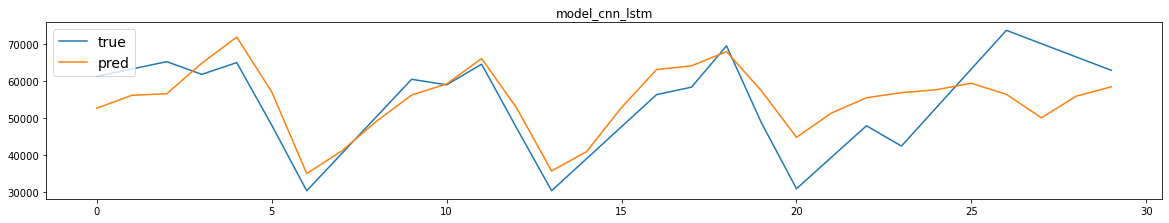

In [249]:
number_plots = 13
number_checked_labels = 30

fig = plt.figure(figsize=(20,50))
x = len(y_test)
y = predicitions[0][0:number_checked_labels,0]

plt.subplot(number_plots, 1, 1)
plt.plot(y_test[0:number_checked_labels,0])
plt.plot(predicitions[0][0:number_checked_labels,0])
plt.legend(['true', 'pred'], loc='upper left',fontsize=14)
plt.title(f'{results[0][0]}')

# plt.subplot(number_plots, 1, 2)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[1][0:number_checked_labels,0])
# plt.title(f'{results[1][0]}')

# plt.subplot(number_plots, 1, 3)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[2][0:number_checked_labels,0])
# plt.title(f'{results[2][0]}')

# plt.subplot(number_plots, 1, 4)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[3][0:number_checked_labels,0])
# plt.title(f'{results[3][0]}')

# plt.subplot(number_plots, 1, 5)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[4][0:number_checked_labels,0])
# plt.title(f'{results[4][0]}')

# plt.subplot(number_plots, 1, 6)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[5][0:number_checked_labels,0])
# plt.title(f'{results[5][0]}')

# plt.subplot(number_plots, 1, 7)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[6][0:number_checked_labels,0])
# plt.title(f'{results[6][0]}')

# plt.subplot(number_plots, 1, 8)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[7][0:number_checked_labels,0])
# plt.title(f'{results[7][0]}')

plt.savefig("poltet_good_architketurs_30", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

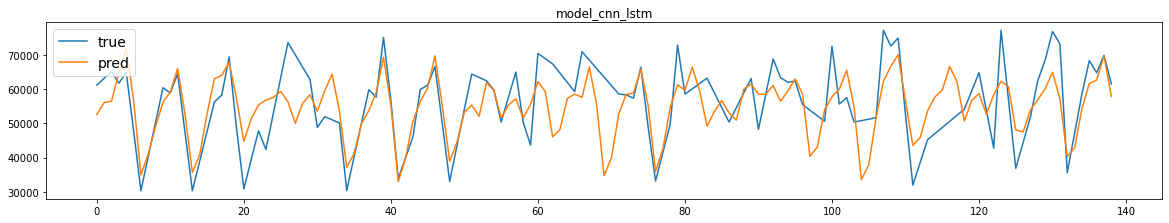

In [248]:
number_plots = 13
number_checked_labels = 190

fig = plt.figure(figsize=(20,50))
x = len(y_test)
y = predicitions[0][0:number_checked_labels,0]

plt.subplot(number_plots, 1, 1)
plt.plot(y_test[0:number_checked_labels,0])
plt.plot(predicitions[0][0:number_checked_labels,0])
plt.legend(['true', 'pred'], loc='upper left',fontsize=14)
plt.title(f'{results[0][0]}')

# plt.subplot(number_plots, 1, 2)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[1][0:number_checked_labels,0])
# plt.title(f'{results[1][0]}')

# plt.subplot(number_plots, 1, 3)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[2][0:number_checked_labels,0])
# plt.title(f'{results[2][0]}')

# plt.subplot(number_plots, 1, 4)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[3][0:number_checked_labels,0])
# plt.title(f'{results[3][0]}')

# plt.subplot(number_plots, 1, 5)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[4][0:number_checked_labels,0])
# plt.title(f'{results[4][0]}')

# plt.subplot(number_plots, 1, 6)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[5][0:number_checked_labels,0])
# plt.title(f'{results[5][0]}')

# plt.subplot(number_plots, 1, 7)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[6][0:number_checked_labels,0])
# plt.title(f'{results[6][0]}')

# plt.subplot(number_plots, 1, 8)
# plt.plot(y_test[0:number_checked_labels,0])
# plt.plot(predicitions[7][0:number_checked_labels,0])
# plt.title(f'{results[7][0]}')

plt.savefig("poltet_good_architketurs_190", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

## Randomsearch

In [ ]:
param_grid = {"epochs": [50,60,70,80,90,100], "batch_size": [32,64,128],
              "filters": [4,8,32,16], "kernel_size": [1,2,3,4,5],
              "pool_size" : [1,2,3,4,5,6],"loss" : ["mse","huber","mae"]}
result = []
keysList = list(param_grid.keys())
for counter in range(0,50):
    rnd = dict()
    parameters = dict()
    for i in keysList: 
        value = random.randint(0,len(param_grid[i])-1)
        rnd[i] = value
        parameters[i] = param_grid[i][value]



    model_history_cnn,model_cnn, x_tests = fit_model_cnn(filters = param_grid["filters"][rnd["filters"]],
                                                         kernel_size = param_grid["kernel_size"][rnd["kernel_size"]],
                                                         pool_size = param_grid["pool_size"][rnd["pool_size"]],
                                                         epochs = param_grid["epochs"][rnd["epochs"]], 
                                                         batch_size = param_grid["batch_size"][rnd["batch_size"]],
                                                         loss = param_grid["loss"][rnd["loss"]],
                                                         optimizer = "adam",
                                                         training = X1_train, 
                                                         y_train = y_train, 
                                                         test = X1_test, 
                                                         y_test = y_test,
                                                         verbose = 0)
    pred = model_prediction("CNN1", model_cnn,x_tests,y_test)
    results_one_model = dict()
    #name,mse,mae,mape, predictions_cnn
    results_one_model["Name"] = pred[0]
    results_one_model["mse"] = pred[1]
    results_one_model["mae"] = pred[2]
    results_one_model["mape"] = pred[3]
    results_one_model["parameters"] = parameters
    result.append(results_one_model)
    print(counter)


In [ ]:
param_grid = {"epochs": [60,70,80,90,100], "batch_size": [256,300,512],
              "filters": [32,16,64,128,256], "kernel_size": [2,3,4],
              "pool_size" : [1,2,],"loss" : ["mse","huber","mae"], "dense1" : [250,270,280,300],
              "dense2" : [50,60,80,70,90,100,150], "lstm_units" : [70,110,150,200,250,300,350,400]}



result = []
keysList = list(param_grid.keys())
for counter in range(0,60):
    rnd = dict()
    parameters = dict()
    for i in keysList: 
        value = random.randint(0,len(param_grid[i])-1)
        rnd[i] = value
        parameters[i] = param_grid[i][value]
        
        
    model_cnn_lstm_multi_history, model_cnn_lstm_multi,test_series_sub = fit_model_lstm_cnn_multi(
                                                        filters = param_grid["filters"][rnd["filters"]],
                                                         kernel_size = param_grid["kernel_size"][rnd["kernel_size"]],
                                                         pool_size = param_grid["pool_size"][rnd["pool_size"]],
                                                         epochs = param_grid["epochs"][rnd["epochs"]], 
                                                         batch_size = param_grid["batch_size"][rnd["batch_size"]],
                                                         loss = param_grid["loss"][rnd["loss"]],
                                                         dense1 = param_grid["dense1"][rnd["dense1"]], 
                                                         dense2 = param_grid["dense2"][rnd["dense2"]],
                                                         lstm_units = param_grid["lstm_units"][rnd["lstm_units"]],
                                                         optimizer = "adam",
                                                         training1 = X1_train,
                                                         training2 = X2_train,
                                                         training3 = X3_train,
                                                         y_train = y_train,
                                                         test1 =X1_test,
                                                         test2 =X2_test,
                                                         test3 =X3_test,
                                                         y_test =y_test,
                                                         verbose = 0)

    pred = model_prediction(f"model_cnn_lstm", model_cnn_lstm_multi,test_series_sub,y_test)
    results_one_model = dict()
    #name,mse,mae,mape, predictions_cnn
    results_one_model["Name"] = pred[0]
    results_one_model["mse"] = pred[1]
    results_one_model["mae"] = pred[2]
    results_one_model["mape"] = pred[3]
    results_one_model["parameters"] = parameters
    result.append(results_one_model)

In [ ]:
param_grid = {"epochs": [50,60,70,80,90,100], "batch_size": [32,64,128],
              "filters": [32,16,64,128], "kernel_size": [1,2,3,4,5],
              "pool_size" : [1,2,3,4,5,6],"loss" : ["mse","huber","mae"]}



result = []
keysList = list(param_grid.keys())
for counter in range(0,50):
    rnd = dict()
    parameters = dict()
    for i in keysList: 
        value = random.randint(0,len(param_grid[i])-1)
        rnd[i] = value
        parameters[i] = param_grid[i][value]

    model_multi_cnn_history, model_multi_cnn = fit_model_CNN_X1_X2(filters1 = param_grid["filters"][rnd["filters"]],
                                                         kernel_size1 = param_grid["kernel_size"][rnd["kernel_size"]],
                                                         pool_size1 = param_grid["pool_size"][rnd["pool_size"]],
                                                         filters2 = param_grid["filters"][rnd["filters"]],
                                                         kernel_size2 = param_grid["kernel_size"][rnd["kernel_size"]],
                                                         pool_size2 = param_grid["pool_size"][rnd["pool_size"]],
                                                         epochs = param_grid["epochs"][rnd["epochs"]], 
                                                         batch_size = param_grid["batch_size"][rnd["batch_size"]],
                                                         loss = param_grid["loss"][rnd["loss"]],
                                                         optimizer = "adam",
                                                         X1_train = X1_train,X2_train = X2_train,X3_train=X3_train,
                                                         y_train = y_train,y_test = y_test,
                                                         verbose = 0)

    pred = model_prediction(f"model_multi_cnn", model_multi_cnn,[X1_test,X2_test, X3_test],y_test)
    results_one_model = dict()
    #name,mse,mae,mape, predictions_cnn
    results_one_model["Name"] = pred[0]
    results_one_model["mse"] = pred[1]
    results_one_model["mae"] = pred[2]
    results_one_model["mape"] = pred[3]
    results_one_model["parameters"] = parameters
    result.append(results_one_model)




In [ ]:
param_grid = {"epochs": [50,60,70,80,90,100], "batch_size": [16,32,64,128],
              "filters": [4,8,32,16], "kernel_size": [1,2],"pool_size" : [1],"loss" : ["mse","huber","mae"]}
result_mulit_CNN = []
keysList = list(param_grid.keys())
for counter in range(0,50):
    rnd = dict()
    parameters = dict()
    for i in keysList: 
        value = random.randint(0,len(param_grid[i])-1)
        rnd[i] = value
        parameters[i] = param_grid[i][value]



    model_multi_cnn2_history,model_multi_cnn2 = fit_model_multi_CNN_X1_X2_X3_X4_X5(
                                                    filters1 = param_grid["filters"][rnd["filters"]],
                                                    filters2 = param_grid["filters"][rnd["filters"]],
                                                    kernel_size1 = param_grid["kernel_size"][rnd["kernel_size"]],
                                                    kernel_size2 = param_grid["kernel_size"][rnd["kernel_size"]],
                                                    pool_size1 = param_grid["pool_size"][rnd["pool_size"]],
                                                    pool_size2 =param_grid["pool_size"][rnd["pool_size"]],
                                                    optimizer = "adam",
                                                    loss = param_grid["loss"][rnd["loss"]],
                                                    X1_train = X1_train,X2_train = X2_train,X3_train = X3_train,
                                                    X4_train = X4_train,X5_train = X5_train,X6_train= X6_train,X6_test = X6_test,
                                                    X1_test = X1_test,X2_test = X2_test,X3_test = X3_test,
                                                    X4_test = X4_test,X5_test = X5_test,
                                                    epochs = param_grid["epochs"][rnd["epochs"]],
                                                    verbose = 0,
                                                    batch_size = param_grid["batch_size"][rnd["batch_size"]])

    pred = model_prediction(f"model_multi_cnn2", model_multi_cnn2,[X1_test,X2_test,X4_test,X5_test,X6_test,X3_test],y_test)
    results_one_model = dict()
    #name,mse,mae,mape, predictions_cnn
    results_one_model["Name"] = pred[0]
    results_one_model["mse"] = pred[1]
    results_one_model["mae"] = pred[2]
    results_one_model["mape"] = pred[3]
    results_one_model["parameters"] = parameters
    result_mulit_CNN.append(results_one_model)


In [ ]:
result_mulit_CNN = pd.DataFrame(result_mulit_CNN)
result_mulit_CNN.to_csv('result_mulit_CNN_random2.csv', index=True, header=True,sep = ";")

# Vorhersage Intervalle und Speichern

In [ ]:
def fit_ensemble(n_members,y_test):
    ensemble = list()
    for i in range(n_members):
        # define and fit the model on the training set
#         model_history_cnn,model_cnn, x_test = fit_model_cnn(filters = 8,kernel_size = 2,pool_size = 1,
#                                              epochs = 90, batch_size = 64,training = X1_train, 
#                                              y_train = y_train, test = X1_test, y_test = y_test,verbose = 0,
#                                              optimizer = "adam",loss="mse")
        
        
        model_cnn_lstm_multi_history, model_cnn_lstm_multi,test_series_sub = fit_model_lstm_cnn_multi(
                                    filters = 128,kernel_size = 2,pool_size = 1,optimizer = "adam",
                                    loss = "mae",training1 = X1_train,training2 = X2_train,training3 = X3_train,y_train = y_train,test1 =X1_test,
                                    test2 =X2_test,test3 =X3_test,y_test =y_test,epochs = 60,batch_size = 256,verbose = 1,dense1 =300, dense2= 150, lstm_units=400)


        results = model_prediction(f"model_cnn_lstm_multi{i}", model_cnn_lstm_multi,test_series_sub,y_test)
        ensemble.append(model_cnn_lstm_multi)
    return ensemble, test_series_sub, y_test

In [ ]:
def get_predic_dic(ensemble,x_tests,y_test):
        
    tests = x_tests   
    predic = {}
    for n in range(0,tests[0].shape[0]):
        true_a = []
        pred_a = []
        upper_a = []
        lower_a = []
        X = []
        for a in range(0,len(tests)):
            X.append(np.expand_dims(tests[a][n], axis=0))  
       # X = X1_test[n].reshape(1,X1_test.shape[1],1)

        yhat = [model.predict(X, verbose=0) for model in ensemble]
        yhat = np.array(yhat)
        yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
        #calculate 95% gaussian prediction interval
        for i in range(0,yhat.shape[1]):
            interval = 1.64 * yhat[:,i].std()
            lower, upper = yhat[:,i].mean() - interval, yhat[:,i].mean() + interval
            pred_a.append(yhat[:,i].mean())
            true_a.append(y_test[n][i])
            lower_a.append(lower)
            upper_a.append(upper)
            #print('Point prediction: %.3f' % yhat[:,i].mean())
            #print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
            #print('True value: %.3f' % y_test[n][i])
        true_a = [round(num, 0) for num in true_a]
        pred_a = [round(num, 0) for num in pred_a]
        lower_a = [round(num, 2) for num in lower_a]
        upper_a = [round(num, 2) for num in upper_a]

        predic["info_{0}".format(n)] = {"true" :true_a,
        "pred": pred_a,
        "lower" :lower_a,
        "upper" :upper_a
            }
    print("Finished predic")
    
    pred_days = {}
    for n in range(0, y_test.shape[1]):
        #gesamten Datensatz durchlaufen 

        # alle predicitons für den jeweiligen tag 
        true_a = []
        pred_a = []
        upper_a = []
        lower_a = []
        
        for i in range(0,tests[0].shape[0]):
            X = []
            for a in range(0,len(tests)):
                X.append(np.expand_dims(tests[a][i], axis=0))
            yhat = [model.predict(X, verbose=0) for model in ensemble]
            yhat = np.array(yhat)
            yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
            #Die vorhersage von x_ensemble models, für den Tag n 
            yhat = yhat[:,n]

            interval = 1.64 * yhat.std()
            lower, upper = yhat.mean() - interval, yhat.mean() + interval
            pred_a.append(yhat.mean())
            true_a.append(y_test[i,n])
            lower_a.append(lower)
            upper_a.append(upper)
            #print('Point prediction: %.3f' % yhat.mean())
            #print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
            #print('True value: %.3f' % y_test[i,n])
        true_a = [round(num, 0) for num in true_a]
        pred_a = [round(num, 0) for num in pred_a]
        lower_a = [round(num, 2) for num in lower_a]
        upper_a = [round(num, 2) for num in upper_a]

        data = {"true_{0}".format(n):true_a,
            "pred_{0}".format(n): pred_a,
            "lower_{0}".format(n) :lower_a,
            "upper_{0}".format(n) :upper_a
               }
        mse = sklearn.metrics.mean_squared_error(true_a, pred_a)
        mae = sklearn.metrics.mean_absolute_error(true_a, pred_a)
        mape = sklearn.metrics.mean_absolute_percentage_error(true_a, pred_a)
        print(f"RMSE_{n}: {math.sqrt(mse)}")
        print(f"MAE_{n}: {mae}")
        print(f"MAPE_{n}: {mape}")
        print("")

        # Create DataFrame    
        pred_days["{0}".format(n)] = data
    print("Finished predic days")
        
    return predic, pred_days

In [ ]:
n_members = 10
ensemble, x_test, y_test= fit_ensemble(n_members,y_test)


In [ ]:
for number in range(0,len(ensemble)):
    ensemble[number].save(f"04_savedModels/model_{number}.pickle")
    


In [ ]:
import pickle
a_file = open("models.pkl", "wb")
pickle.dump(ensemble, a_file)
a_file.close()

In [ ]:
c_pre,c_pre_days= get_predic_dic(ensemble, x_test, y_test)

In [ ]:
import pickle
a_file = open("pred.pkl", "wb")
pickle.dump(c_pre, a_file)
a_file.close()

In [ ]:
data_naive = {'true_naive': y_test[1:,0].tolist(),
        'pred_naive': y_test[0:y_test.shape[0] -1,0].tolist()
        }
df_naive = pd.DataFrame(data_naive).round({'true': 0, 'pred': 0})

In [ ]:
df1 = pd.DataFrame(c_pre_days["0"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df2 = pd.DataFrame(c_pre_days["1"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df3 = pd.DataFrame(c_pre_days["2"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df4 = pd.DataFrame(c_pre_days["3"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df5 = pd.DataFrame(c_pre_days["4"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df6 = pd.DataFrame(c_pre_days["5"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df7 = pd.DataFrame(c_pre_days["6"]).round({'true': 0, 'pred': 0,"lower":0,"upper":0})
df1.to_csv('01_Results/pred_day1.csv', index=True, header=True,sep = ";")
df2.to_csv('01_Results/pred_day2.csv', index=True, header=True,sep = ";")
df3.to_csv('01_Results/pred_day3.csv', index=True, header=True,sep = ";")
df4.to_csv('01_Results/pred_day4.csv', index=True, header=True,sep = ";")
df5.to_csv('01_Results/pred_day5.csv', index=True, header=True,sep = ";")
df6.to_csv('01_Results/pred_day6.csv', index=True, header=True,sep = ";")
df7.to_csv('01_Results/pred_day7.csv', index=True, header=True,sep = ";")
df_naive.to_csv('01_Results/pred_naive_oneDay.csv', index=True, header=True,sep = ";")